## <center>Seq2Seq Learning & Neural Machine Translation</center>

Sequence to sequence learning (Seq2Seq) is about training models to convert sequences from one domain (e.g. sentences in Chinese) to sequences in another domain (e.g. the same sentences translated to English). This can be used for machine translation, free-form question answering (generating a natural language answer given a natural language question), text summarization, and image captioning. In general, it is applicable any time you need to generate text.

In this lab, we will introduce how to train a seq2seq model for Chinese to English translation. After training the model in this notebook, you will be able to input a Chinese sentence, such as "你今晚會去派對嗎?", and return the English translation: "will you go to the party tonight?".

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

進行序列到序列學習（Seq2Seq）的目的是訓練模型將一個領域的序列（例如中文句子）轉換為另一個領域的序列（例如相同句子的英文翻譯）。這可以用於機器翻譯、自由形式的問答（根據自然語言問題生成自然語言答案）、文本摘要和圖像標註等應用。總的來說，它適用於任何需要生成文本的情況。

在這個實驗室中，我們將介紹如何訓練一個用於中文到英文翻譯的Seq2Seq模型。在這個筆記本中訓練完模型後，您將能夠輸入一個中文句子，例如"你今晚會去派對嗎?"，並返回英文翻譯："will you go to the party tonight?"。

儘管這是一個簡單的示例，翻譯的質量還算合理，但生成的注意力圖可能更有趣。這顯示了模型在翻譯時對輸入句子的哪些部分進行了注意力：

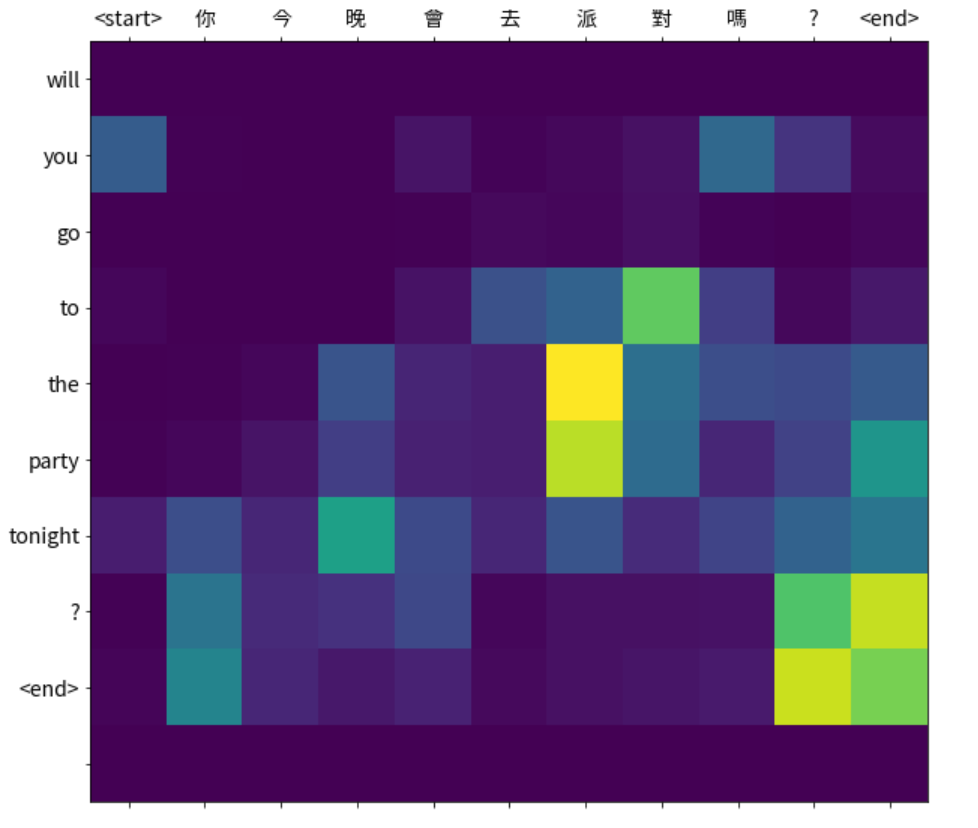

### Encoder-Decoder Architecture

The encoder-decoder architecture is a neural network design pattern. In this architecture, the network is partitioned into two parts, the encoder and the decoder. The encoder’s role is encoding the inputs into hidden state, or hidden representation, which often contains several tensors. Then the hidden state is passed into the decoder to generate the outputs.


編碼器-解碼器架構是一種神經網絡設計模式。在這種架構中，網絡被分為兩個部分，即編碼器和解碼器。編碼器的作用是將輸入編碼成隱藏狀態或隱藏表示，通常包含多個張量。然後，將隱藏狀態傳遞到解碼器，以生成輸出。

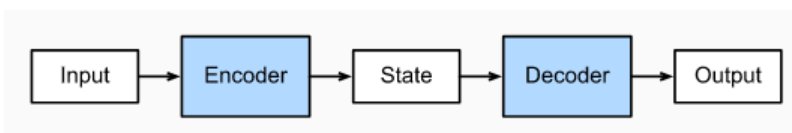

### Sequence to Sequence

The sequence to sequence (seq2seq) model is based on the encoder-decoder architecture to generate a sequence output for a sequence input, where both the encoder and the decoder tend to both be recurrent neural networks (RNNs). The hidden state of the encoder is used directly to initialize the hidden state of decoder, bringing information from the encoder to the decoder. In machine translation, the encoder transforms a source sentence, i.e. “你今晚會去派對嗎?”, into hidden state, which is a vector, that captures its semantic information. The decoder then uses this state to generate the translated target sentence, e.g. “will you go to the party tonight?”.

序列到序列（seq2seq）模型基於編碼器-解碼器架構，用於為序列輸入生成序列輸出。在這種架構中，編碼器和解碼器通常都是循環神經網絡（RNNs）。編碼器的隱藏狀態直接用於初始化解碼器的隱藏狀態，將信息從編碼器傳遞到解碼器。在機器翻譯中，編碼器將源句子（例如"你今晚會去派對嗎?"）轉換為一個包含其語義信息的向量的隱藏狀態。然後，解碼器使用這個狀態生成翻譯的目標句子，例如"will you go to the party tonight?"。

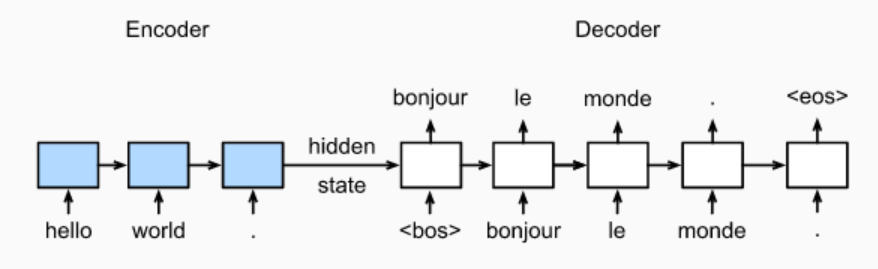

### Sequence to Sequence with Attention Mechanism

Now, let’s talk about the attention mechanism. What is it and why do we need it?

Let’s use Neural Machine Translation (NMT) as an example. In NMT, the encoder maps the meaning of a sentence into a fixed-length hidden representation, this representation is expected to be a good summary of the entire input sequence, where the decoder can generate a corresponding translation based on that vector.

A critical and apparent disadvantage of this fixed-length context vector design is the **incapability of the system to remember longer sequences**. It is common to see that the fixed-length vector forgot the earlier parts of the input sentence once it has processed the entire input. A solution we proposed in Bahdanau et al., 2014 and Luong et al., 2015.. These papers introduced and refined a technique called Attention, which highly improved the quality of machine translation systems. **Attention** allows the model to focus on the relevant parts of the input sequence as needed.

That was the idea behind Attention! It can be illustrated as follows:

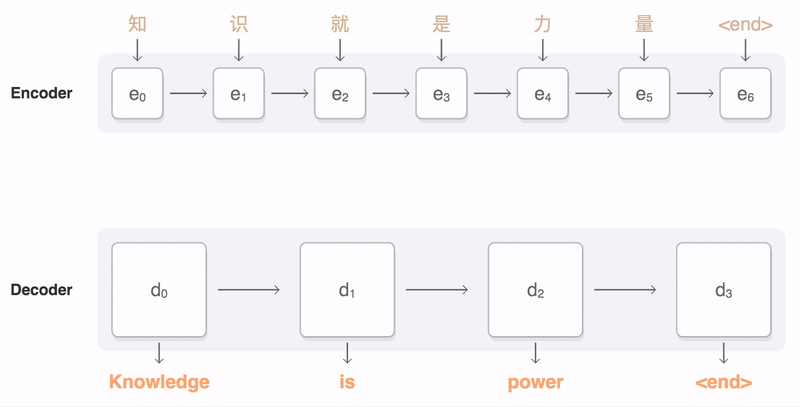

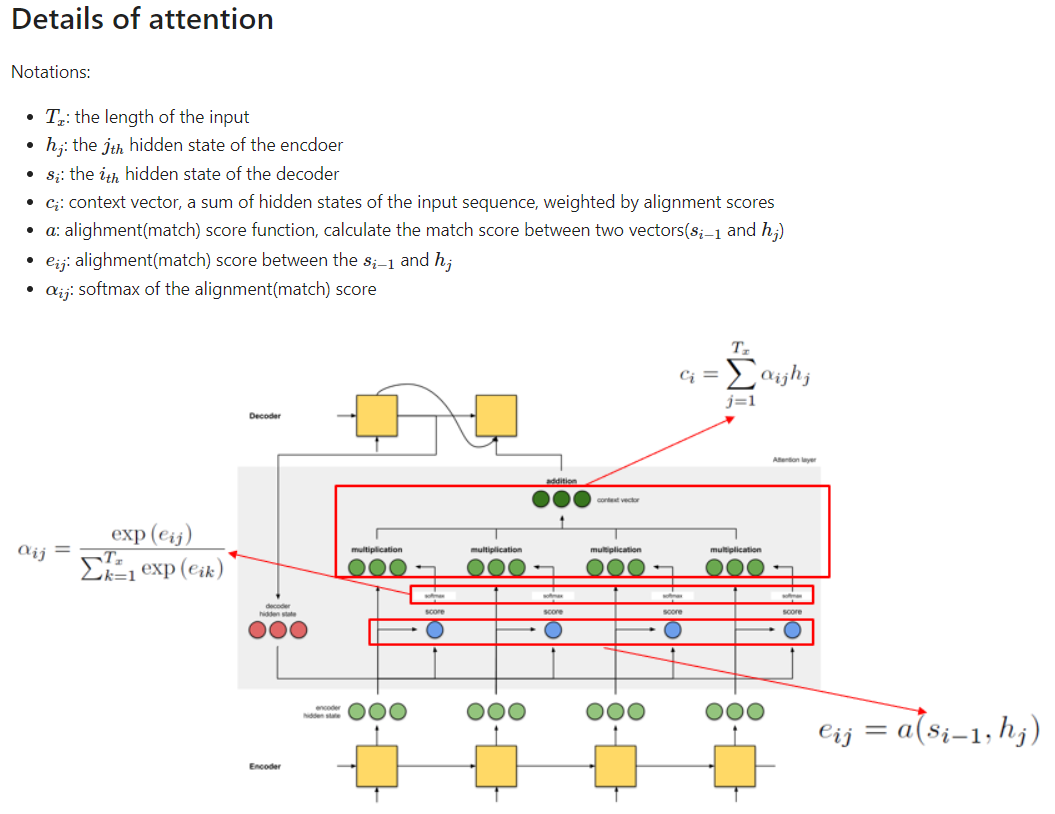

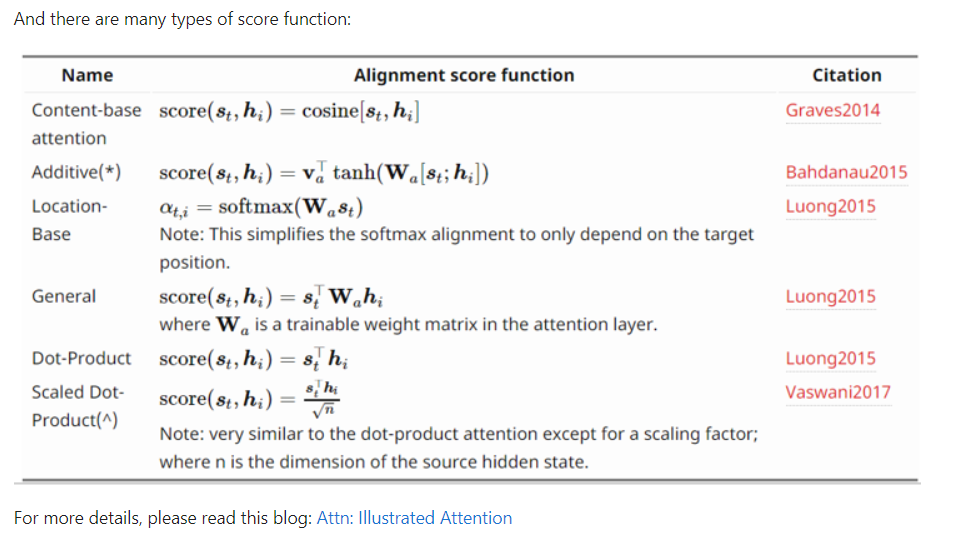

### Teacher Forcing

Teacher forcing is an efficient and effective method used widely in the training process of recurrent neural networks, which uses the ground truth from a previous time step as the input to the next time step.

## <center>Neural Machine Translation</center>

Next, we will show how to train a seq2seq model using a translation dataset (Chinese to English), and then we will demonstrate some results of the translation to evaluate the model. In this lab, we will use GRU(Gated Recurrent Unit) layers.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import unicodedata
import re
import numpy as np
import os
import time
from sklearn.model_selection import train_test_split

from pylab import *
from matplotlib.font_manager import FontProperties

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


### Prepare the dataset

In [3]:
# dataset path
# use the Chinese-English dataset
path_to_file = "./data/eng-chinese.txt"

### Data preprocessing

1. Add a start and end token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

### 數據預處理

1. 對每個句子添加開始和結束標記。
2. 通過刪除特殊字符來清理句子。
3. 創建單詞索引和反向單詞索引（將單詞映射到ID和ID映射到單詞的字典）。
4. 對每個句子進行填充，使其達到最大長度。

In [4]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')


def preprocess_eng(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/
    # python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,])", r" \1 ", w)
    # replace several spaces with one space
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,]+", " ", w)
    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w


def preprocess_chinese(w):
    w = unicode_to_ascii(w.lower().strip())
    w = re.sub(r'[" "]+', "", w)
    w = w.rstrip().strip()
    w = " ".join(list(w))  # add the space between words
    w = '<start> ' + w + ' <end>'
    return w

In [5]:
# u means unicode encoder
en_sentence = u"May I borrow this book?"
chn_sentence = u"我可以借這本書麼？"
print(preprocess_eng(en_sentence))
print(preprocess_chinese(chn_sentence))
print(preprocess_chinese(chn_sentence).encode('utf-8'))

<start> may i borrow this book ? <end>
<start> 我 可 以 借 這 本 書 麼 ？ <end>
b'<start> \xe6\x88\x91 \xe5\x8f\xaf \xe4\xbb\xa5 \xe5\x80\x9f \xe9\x80\x99 \xe6\x9c\xac \xe6\x9b\xb8 \xe9\xba\xbc \xef\xbc\x9f <end>'


In [6]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, CHINESE]
def create_dataset(path, num_examples=None):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    word_pairs = [[w for w in l.split('\t')] for l in lines[:num_examples]]
    word_pairs = [[preprocess_eng(w[0]), preprocess_chinese(w[1])]
                  for w in word_pairs]

    # return two tuple: one tuple includes all English sentenses, and 
    # another tuple includes all Chinese sentenses
    return word_pairs


word_pairs = create_dataset(path_to_file)
# show the first twenty examples
word_pairs[:20]

[['<start> hi . <end>', '<start> 嗨 。 <end>'],
 ['<start> hi . <end>', '<start> 你 好 。 <end>'],
 ['<start> run . <end>', '<start> 你 用 跑 的 。 <end>'],
 ['<start> wait ! <end>', '<start> 等 等 ！ <end>'],
 ['<start> hello ! <end>', '<start> 你 好 。 <end>'],
 ['<start> i try . <end>', '<start> 让 我 来 。 <end>'],
 ['<start> i won ! <end>', '<start> 我 赢 了 。 <end>'],
 ['<start> oh no ! <end>', '<start> 不 会 吧 。 <end>'],
 ['<start> cheers ! <end>', '<start> 乾 杯 ! <end>'],
 ['<start> he ran . <end>', '<start> 他 跑 了 。 <end>'],
 ['<start> hop in . <end>', '<start> 跳 进 来 。 <end>'],
 ['<start> i lost . <end>', '<start> 我 迷 失 了 。 <end>'],
 ['<start> i quit . <end>', '<start> 我 退 出 。 <end>'],
 ['<start> i m ok . <end>', '<start> 我 沒 事 。 <end>'],
 ['<start> listen . <end>', '<start> 听 着 。 <end>'],
 ['<start> no way ! <end>', '<start> 不 可 能 ！ <end>'],
 ['<start> no way ! <end>', '<start> 没 门 ！ <end>'],
 ['<start> really ? <end>', '<start> 你 确 定 ？ <end>'],
 ['<start> try it . <end>', '<start> 试 试 吧 。 <end>'],
 ['

In [7]:
en, chn = zip(*create_dataset(path_to_file))
print(en[-1])
print(chn[-1])
# show the size of the dataset
assert len(en) == len(chn)
print("Size:", len(en))

<start> if a person has not had a chance to acquire his target language by the time he s an adult , he s unlikely to be able to reach native speaker level in that language . <end>
<start> 如 果 一 個 人 在 成 人 前 沒 有 機 會 習 得 目 標 語 言 ， 他 對 該 語 言 的 認 識 達 到 母 語 者 程 度 的 機 會 是 相 當 小 的 。 <end>
Size: 20289


In [8]:
def max_length(tensor):
    # padding the sentence to max_length
    return max(len(t) for t in tensor)

def tokenize(lang):
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
        filters='')
    # generate a dictionary, e.g. word -> index(of the dictionary)
    lang_tokenizer.fit_on_texts(lang)

    # output the vector sequences, e.g. [1, 7, 237, 3, 2]
    tensor = lang_tokenizer.texts_to_sequences(lang)

    # padding sentences to the same length
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                           padding='post')
    return tensor, lang_tokenizer

def load_dataset(path, num_examples=None):
    # creating cleaned input, output pairs
    # regard Chinese as source sentence, regard English as target sentence
    targ_lang, inp_lang = zip(*create_dataset(path, num_examples))

    input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
    target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

    return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [9]:
# Try experimenting with the size of that dataset
# num_examples = 10000, if num examples = None means no limitation
num_examples = None
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(
    path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = max_length(
    target_tensor), max_length(input_tensor)

# Creating training and validation sets using an 95-5 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(
    input_tensor, target_tensor, test_size=0.05)

# Show length of the training data and validation data
print("# training data: {:d}\n# test data: {:d}".format(len(input_tensor_train), len(input_tensor_val)))

# training data: 19274
# test data: 1015


In [10]:
def convert(lang, tensor):
    for t in tensor:
        if t != 0:
            print("%d ----> %s" % (t, lang.index_word[t]))

print("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print()
print("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
8 ----> 他
1454 ----> 負
1283 ----> 責
17 ----> 這
23 ----> 個
399 ----> 部
356 ----> 門
3 ----> 。
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
11 ----> he
17 ----> s
14 ----> in
1213 ----> charge
16 ----> of
5 ----> the
1704 ----> department
3 ----> .
2 ----> <end>


### Create a tf.data dataset

In [11]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 128
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 256
units = 1024
# 0 is a reserved index that won't be assigned to any word, so the size of vocabulary should add 1
vocab_inp_size = len(inp_lang.word_index) + 1
vocab_tar_size = len(targ_lang.word_index) + 1

dataset = tf.data.Dataset.from_tensor_slices(
    (input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([128, 46]), TensorShape([128, 38]))

### Encoder

In [12]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        # vacab_size=vocab_inp_size=9394, embedding_dim=256 enc_units=1024 batch_sz=128
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.enc_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_activation='sigmoid',
                                       recurrent_initializer='glorot_uniform')

    def call(self, x, hidden):
        # x is the training data with shape == (batch_size, max_length)  -> (128, 46)
        # which means there are batch_size sentences in one batch, the length of each sentence is max_length
        # hidden state shape == (batch_size, units) -> (128, 1024)
        # after embedding, x shape == (batch_size, max_length, embedding_dim) -> (128, 46, 256)
        x = self.embedding(x)
        
        # output contains the state(in GRU, the hidden state and the output are same) from all timestamps,
        # output shape == (batch_size, max_length, units) -> (128, 46, 1024)
        # state is the hidden state of the last timestamp, shape == (batch_size, units) -> (128, 1024)
        output, state = self.gru(x, initial_state=hidden)
        
        return output, state

    def initialize_hidden_state(self):
        # initialize the first state of the gru,  shape == (batch_size, units) -> (128, 1024)
        return tf.zeros((self.batch_sz, self.enc_units))

In [13]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)
print('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

# the output and the hidden state of GRU is equal
print(sample_output[-1, -1, :] == sample_hidden[-1, :])

Encoder output shape: (batch size, sequence length, units) (128, 46, 1024)
Encoder Hidden state shape: (batch size, units) (128, 1024)
tf.Tensor([ True  True  True ...  True  True  True], shape=(1024,), dtype=bool)


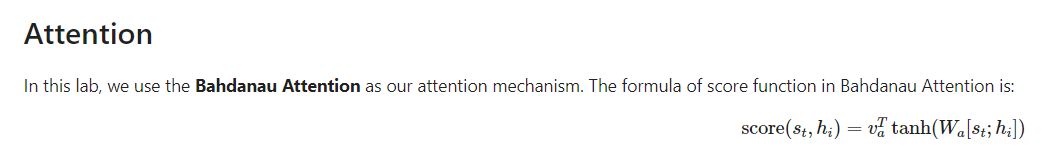

In [14]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(self.W1(values) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape == (batch_size, max_length, hidden_size)
        context_vector = attention_weights * values
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [15]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (128, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (128, 46, 1)


### Decoder

In [16]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        # vocab_size=vocab_tar_size=6082, embedding_dim=256, dec_units=1024, batch_sz=128
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.dec_units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        # the dimension of the output is the vocab size, through the softmax function,
        # this layer will return the probability of each word in the dictory
        self.fc = tf.keras.layers.Dense(vocab_size)

        # used for attention
        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, hidden, enc_output):
        # This function outputs a result at each timestamp
        # The hidden state of fisrt timestamp in the decoder is 
        # the hidden state of last timestamp in the encoder
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # concatenate the input x and the context_vector, as the input of the GRU
        # context_vector shape == (batch_size, units) -> (128, 1024)
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size) -> (128, 1, 1024 + 256)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        # get the output and state of the current timestamp
        # output shape == (batch_size, 1, units) -> (128, 1, 1024) 
        # state shape == (batch_size, units) -> (128, 1024)
        output, state = self.gru(x)

        # output shape == (batch_size, hidden_size) -> (128, 1024)
        output = tf.reshape(output, (-1, output.shape[2]))

        # output shape == (batch_size, vocab) -> (128, 6082)
        x = self.fc(output)

        return x, state, attention_weights

In [17]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)
sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden, sample_output)
print('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (128, 6082)


### Define the optimizer and the loss function

In [18]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    """Calculate the loss value
    Args:
        real: the true label  shape == (batch_size,) -> (128,)
        pred: the probability of each word from the vocabulary, is the output from the decoder 
                 shape == (batch_size, vocab_size) -> (128, 6082)

    Returns: 
        the average loss of the data in a batch size
    """
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

### Checkpoints (Object-based saving)

In [19]:
checkpoint_dir = './checkpoints/chinese-eng'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

### Training

1. Pass the input through the encoder which return encoder output and the encoder hidden state.
2. The encoder output, encoder hidden state and the decoder input (which is the start token) is passed to the decoder.
3. The decoder returns the predictions and the decoder hidden state.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use teacher forcing to decide the next input to the decoder.
6. Teacher forcing is the technique where the target word is passed as the next input to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

### 訓練

1. 通過編碼器將輸入傳遞，獲得編碼器輸出和編碼器隱藏狀態。
2. 編碼器輸出、編碼器隱藏狀態和解碼器輸入（即開始標記）傳遞給解碼器。
3. 解碼器返回預測和解碼器隱藏狀態。
4. 然後將解碼器隱藏狀態重新傳遞到模型中，使用預測值計算損失。
5. 使用教師強制來決定傳遞給解碼器的下一個輸入。
6. 教師強制是一種技術，其中目標單詞被作為下一個輸入傳遞給解碼器。
7. 最後一步是計算梯度，應用於優化器並進行反向傳播。

In [20]:
@tf.function
def train_step(inp, targ, enc_hidden):
    loss = 0

    with tf.GradientTape() as tape:
        enc_output, enc_hidden = encoder(inp, enc_hidden)

        dec_hidden = enc_hidden
        
        # feed the <start> as the first input of the decoder
        # dec input shape == (batch_size, 1) -> (128, 1)
        dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

        # Teacher forcing - feeding the target as the next input
        # because of the data preprocessing(add a start token to the sentence)
        # the first word is <start>, so t starts from 1(not 0)
        for t in range(1, targ.shape[1]):
            # passing enc_output to the decoder
            predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

            # targ[:, t] is the true label(index of the word) of every sentence(in a batch) 
            # at the current timestamp
            # like [  85   18   25   25  ···  1047   79   13], shape == (batch_size,) -> (128,)
            # predictions shape == (batch_size, vocab_size) -> (128, 6082)
            loss += loss_function(targ[:, t], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(targ[:, t], 1)

    batch_loss = (loss / int(targ.shape[1]))

    # collect all trainable variables
    variables = encoder.trainable_variables + decoder.trainable_variables

    # calculate the gradients for the whole variables
    gradients = tape.gradient(loss, variables)

    # apply the gradients on the variables
    optimizer.apply_gradients(zip(gradients, variables))

    return batch_loss

In [21]:
# set the epochs for training
EPOCHS = 50

for epoch in range(EPOCHS):
    start = time.time()

    # get the initial hidden state of gru
    enc_hidden = encoder.initialize_hidden_state()
    total_loss = 0

    for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
        batch_loss = train_step(inp, targ, enc_hidden)
        total_loss += batch_loss

        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))

    # saving (checkpoint) the model every 5 epochs
    if (epoch + 1) % 5 == 0:
        checkpoint.save(file_prefix=checkpoint_prefix)
        
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 1.9794
Epoch 1 Batch 100 Loss 1.0392
Epoch 1 Loss 1.1546
Time taken for 1 epoch 84.76493239402771 sec

Epoch 2 Batch 0 Loss 1.0070
Epoch 2 Batch 100 Loss 0.8941
Epoch 2 Loss 0.9169
Time taken for 1 epoch 51.10848140716553 sec

Epoch 3 Batch 0 Loss 0.7968
Epoch 3 Batch 100 Loss 0.8255
Epoch 3 Loss 0.8081
Time taken for 1 epoch 51.07201099395752 sec

Epoch 4 Batch 0 Loss 0.7593
Epoch 4 Batch 100 Loss 0.7932
Epoch 4 Loss 0.7305
Time taken for 1 epoch 51.17071890830994 sec

Epoch 5 Batch 0 Loss 0.6844
Epoch 5 Batch 100 Loss 0.6943
Epoch 5 Loss 0.6645
Time taken for 1 epoch 51.75633668899536 sec

Epoch 6 Batch 0 Loss 0.6195
Epoch 6 Batch 100 Loss 0.5407
Epoch 6 Loss 0.5999
Time taken for 1 epoch 51.21288824081421 sec

Epoch 7 Batch 0 Loss 0.5645
Epoch 7 Batch 100 Loss 0.5448
Epoch 7 Loss 0.5381
Time taken for 1 epoch 51.13540983200073 sec

Epoch 8 Batch 0 Loss 0.4819
Epoch 8 Batch 100 Loss 0.4887
Epoch 8 Loss 0.4745
Time taken for 1 epoch 51.14649224281311 sec

Epoch 9 

### Translate

- The evaluate function is similar to the training loop, except we don't use teacher forcing here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
- Stop predicting when the model predicts the end token.
- And store the attention weights for every time step.

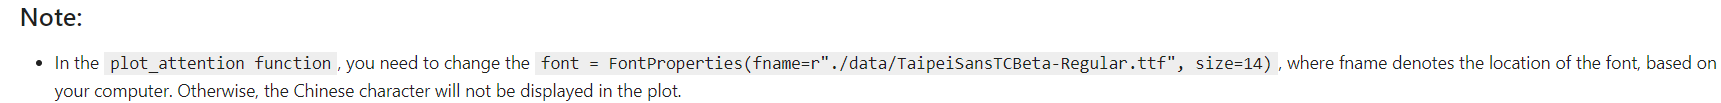

In [22]:
def evaluate(sentence):
    """Translate a sentence
    Args:
        sentence: the test sentence        
    """
    
    # max_length_targ 38, max_length_inp 64
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = preprocess_chinese(sentence)

    # convert each word to the index in the test sentence
    inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')

    inputs = tf.convert_to_tensor(inputs)

    result = ''

    # hidden shape == (1, 1024)
    hidden = [tf.zeros((1, units))]
    
    # enc out shape == (1, max_length_inp, 1024) -> (1, 46, 1024)
    # enc hidden shape == (1, 1024)
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weigths to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        # get the index which has the highest probability
        predicted_id = tf.argmax(predictions[0]).numpy()
        #  convert the index to the word
        result += targ_lang.index_word[predicted_id] + ' '

        # when the decoder predicts the end, stop prediction
        if targ_lang.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted id is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot


# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    # you need to change the fname based on your system, and the Chinese can be displayed in the plot
    font = FontProperties(fname=r"./data/TaipeiSansTCBeta-Regular.ttf", size=14)
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    # set the x-tick/y-tick labels with list of string labels
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, fontproperties=font)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict, fontproperties=font)

    # set tick locators
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

def translate(sentence):
    result, sentence, attention_plot = evaluate(sentence)
    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

### Restore the latest checkpoint and test


In [23]:
checkpoint_dir = './checkpoints/chinese-eng'
print(tf.train.latest_checkpoint(checkpoint_dir))

# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

./checkpoints/chinese-eng\ckpt-10


Input: <start> 你 今 晚 會 去 派 對 嗎 ? <end>
Predicted translation: will you go to the party tonight ? <end> 


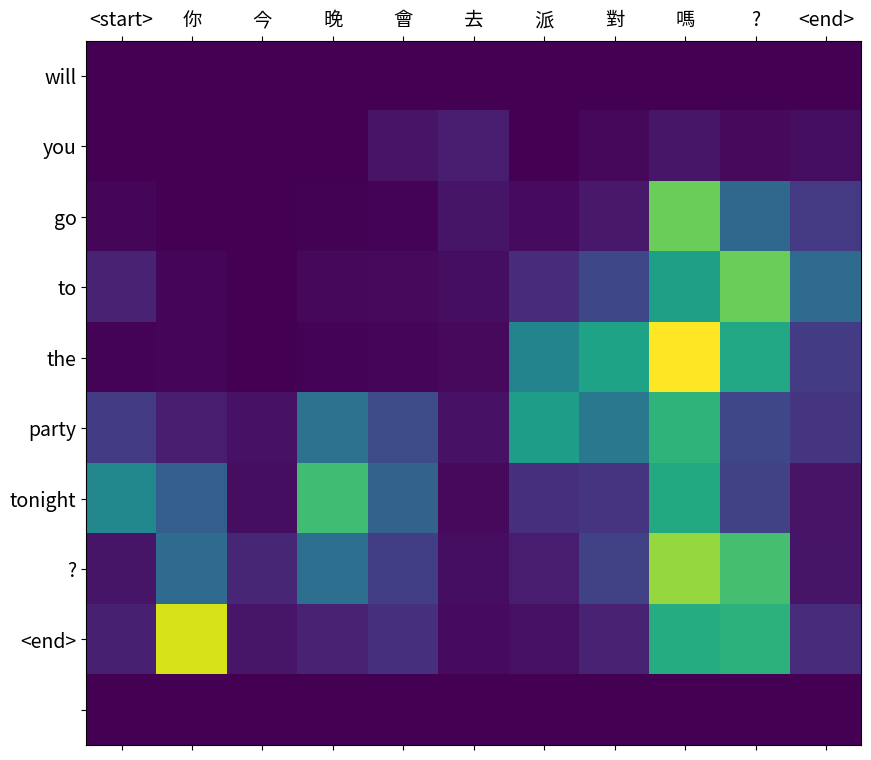

In [24]:
translate('你今晚會去派對嗎?')

Input: <start> 我 有 一 隻 貓 。 <end>
Predicted translation: i have a cat . <end> 


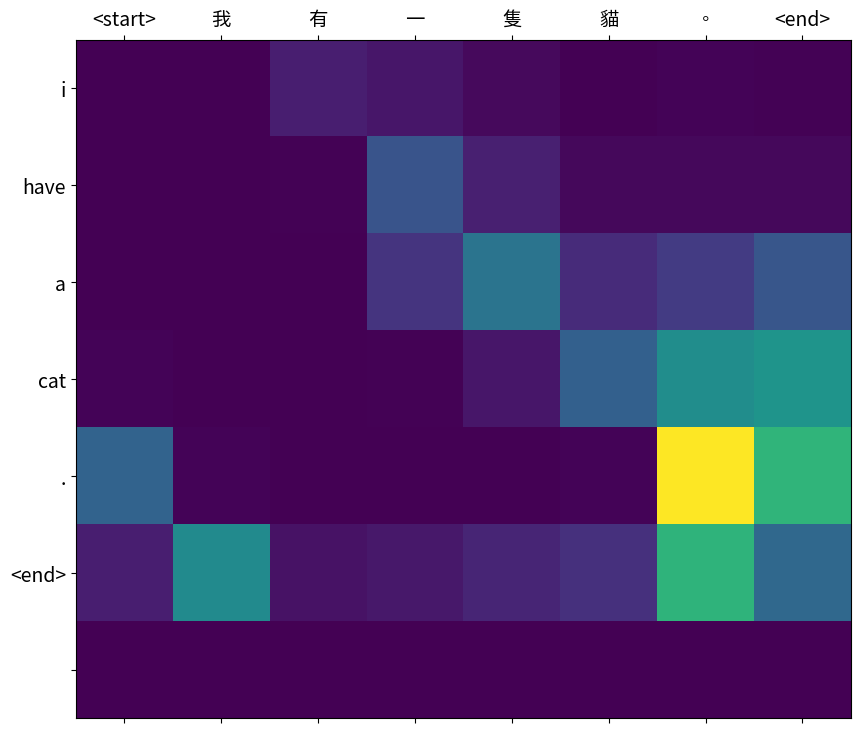

In [25]:
translate('我有一隻貓。')

Input: <start> 她 明 年 會 去 美 國 嗎 ? <end>
Predicted translation: will she go to america next year ? <end> 


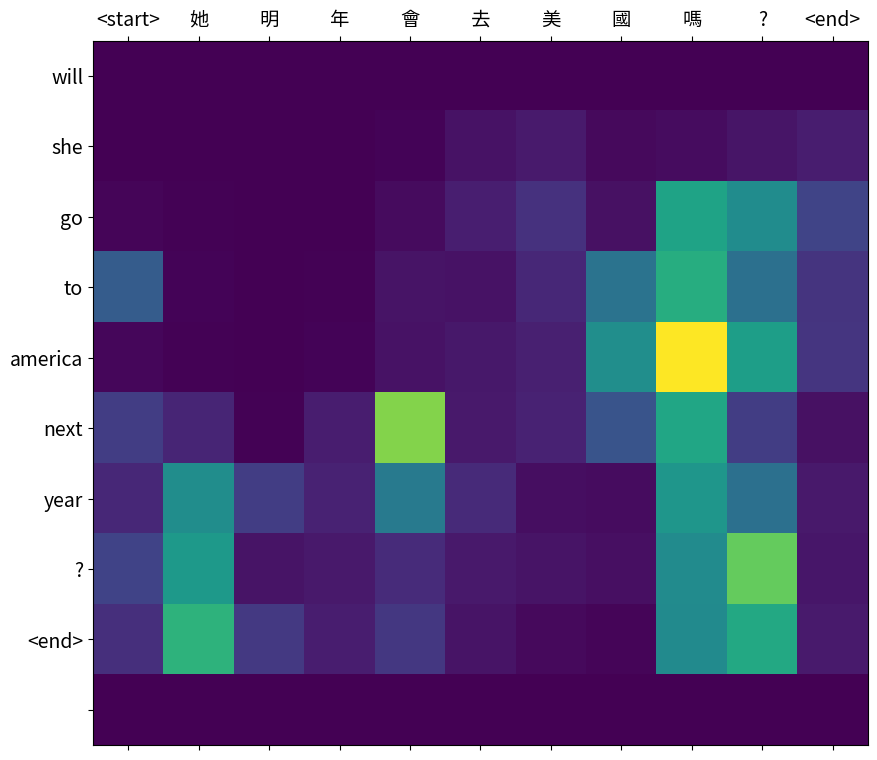

In [26]:
translate('她明年會去美國嗎?')